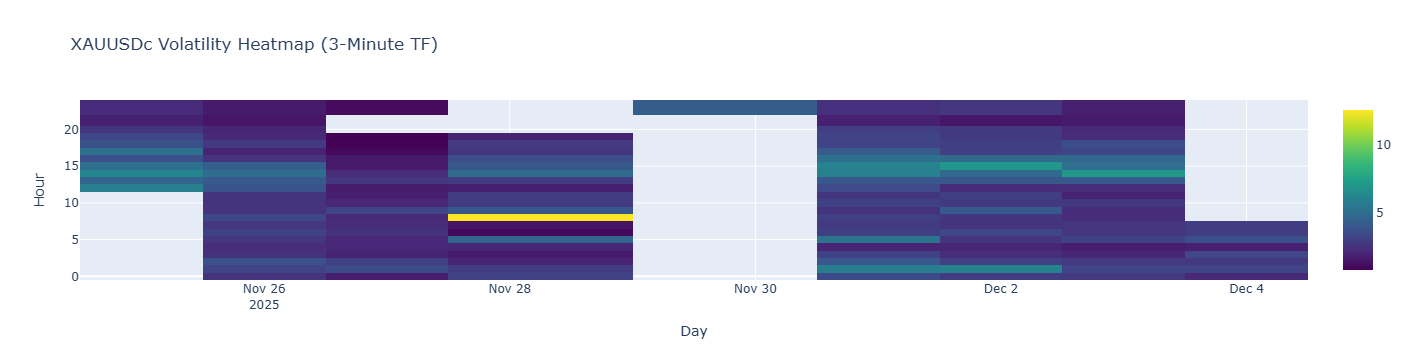

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# -------------------------------
# MT5 Initialize
# -------------------------------
mt5.initialize()

symbol = "XAUUSDc"
tf = mt5.TIMEFRAME_M3
bars = 3000

rates = mt5.copy_rates_from_pos(symbol, tf, 0, bars)
df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s")

# -------------------------------
# Volatility Calculation
# -------------------------------
df["volatility"] = df["high"] - df["low"]

df["hour"] = df["time"].dt.hour
df["day"] = df["time"].dt.date

pivot = df.pivot_table(
    values="volatility",
    index="hour",
    columns="day",
    aggfunc="mean"
)

# -------------------------------
# Heatmap
# -------------------------------
fig = go.Figure(data=go.Heatmap(
    z=pivot.values,
    x=pivot.columns.astype(str),
    y=pivot.index,
    colorscale="Viridis"
))

fig.update_layout(
    title="XAUUSDc Volatility Heatmap (3-Minute TF)",
    xaxis_title="Day",
    yaxis_title="Hour"
)

fig.show()


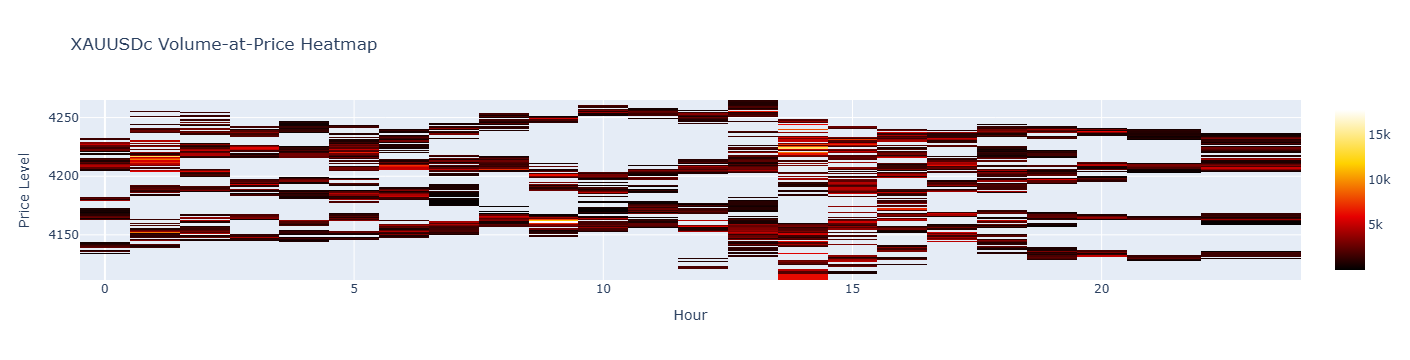

In [2]:
df["price_bin"] = (df["close"] / 1).round(0)

heatmap = df.pivot_table(
    values="tick_volume",
    index="price_bin",
    columns="hour",
    aggfunc="sum"
)

fig = go.Figure(go.Heatmap(
    z=heatmap.values,
    x=heatmap.columns,
    y=heatmap.index,
    colorscale="Hot"
))

fig.update_layout(
    title="XAUUSDc Volume-at-Price Heatmap",
    xaxis_title="Hour",
    yaxis_title="Price Level"
)

fig.show()


Initializing MT5...
Fetching 2000 bars for XAUUSDc...
Bars fetched: 2000. Range: 2025-11-24 21:50:00 -> 2025-12-04 09:55:00
Detecting nodes from bars...
Candidate nodes: 1523 (top by volume shown)
Attempting to fetch ticks for delta computation (may be slow)...
Ticks fetched: 100000 (using to compute delta)
Top zones to plot: 92
Zones exported to: C:\Users\User\xau_bubbles_zones.csv
Plotting chart (Plotly)...


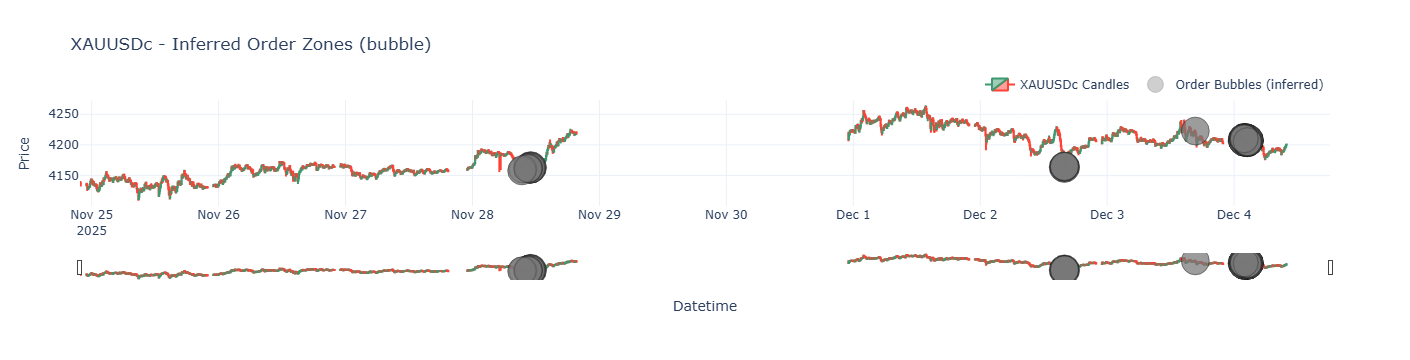

Shutting down MT5 connection.


In [3]:
"""
xau_bubbles_mt5.py
High-placed-orders (bubble) indicator using MT5 XAUUSDc data.

Adjust parameters in the CONFIG section.

Author: generated by ChatGPT (GPT-5 Thinking mini)
"""
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import datetime as dt
import time
import math
import os

# Optional plotting libs
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# -----------------------
# CONFIG (adjust here)
# -----------------------
SYMBOL = "XAUUSDc"                 # symbol in MT5
TIMEFRAME = mt5.TIMEFRAME_M5       # timeframe (M1, M5, M15, H1...)
LOOKBACK_BARS = 2000               # number of bars to fetch
USE_TICKS_FOR_DELTA = True         # whether to attempt approximate buy/sell delta using ticks
TICK_AGGREGATION_LIMIT = 100_000   # max ticks to fetch (guard)
VOLUME_QUANTILE = 0.94             # quantile threshold (e.g., top 6% volumes)
MIN_BUBBLE_RADIUS = 8              # minimal bubble marker size
BUBBLE_SCALE_FACTOR = 0.06         # scale: how bubble area grows with volume (tweak)
MIN_TOUCHES = 2                    # require price level to have been touched at least this many times
PRICE_LEVEL_STEP = 0.10            # bin size in price units for grouping nodes (0.1 = 0.1 dollar)
OUTPUT_CSV = "xau_bubbles_zones.csv"
PLOTLY_OPEN_IN_BROWSER = True      # whether to call fig.show()

# plotting date range override (None uses fetched data)
PLOT_FROM = None  # e.g., dt.datetime(2025, 12, 1)
PLOT_TO = None    # e.g., dt.datetime(2025, 12, 4)


# -----------------------
# UTIL FUNCTIONS
# -----------------------
def mt5_init_or_exit():
    if not mt5.initialize():
        raise RuntimeError(f"MT5 initialization failed, error={mt5.last_error()}")
    # ensure symbol is available
    if not mt5.symbol_select(SYMBOL, True):
        raise RuntimeError(f"Failed to select symbol {SYMBOL}: {mt5.last_error()}")


def fetch_bars(symbol, timeframe, count):
    # fetch most recent `count` bars
    bars = mt5.copy_rates_from_pos(symbol, timeframe, 0, int(count))
    if bars is None or len(bars) == 0:
        raise RuntimeError("No bars returned from MT5.")
    df = pd.DataFrame(bars)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df = df.set_index('time')
    return df


def price_bin(price, step):
    """Round price to nearest bucket center for grouping nodes."""
    # choose quantization that groups prices into bins of size `step`
    return round(round(price / step) * step, 2)


def fetch_ticks_range(symbol, dt_from, dt_to, max_ticks=TICK_AGGREGATION_LIMIT):
    """
    Fetch ticks between dt_from and dt_to (both are timezone-naive datetimes UTC)
    Returns DataFrame with columns: time, bid, ask, last, volume
    """
    # convert to timestamp
    from_ts = int(dt_from.timestamp())
    to_ts = int(dt_to.timestamp())
    ticks = mt5.copy_ticks_range(symbol, from_ts, to_ts, mt5.COPY_TICKS_ALL)
    if ticks is None or len(ticks) == 0:
        return pd.DataFrame()
    df_ticks = pd.DataFrame(ticks)
    # convert time_msc to datetime
    if 'time_msc' in df_ticks.columns:
        df_ticks['time'] = pd.to_datetime(df_ticks['time_msc'], unit='ms')
    elif 'time' in df_ticks.columns:
        df_ticks['time'] = pd.to_datetime(df_ticks['time'], unit='s')
    df_ticks = df_ticks.set_index('time')
    # enforce max
    if len(df_ticks) > max_ticks:
        df_ticks = df_ticks.iloc[-max_ticks:]
    return df_ticks


# -----------------------
# CORE: detect high-volume nodes and compute deltas
# -----------------------
def detect_nodes_from_bars(df_bars, price_step=PRICE_LEVEL_STEP, min_touches=MIN_TOUCHES, quantile=VOLUME_QUANTILE):
    """
    Creates a table of price-level nodes grouped by `price_step`.
    Uses tick_volume per bar as volume proxy.
    """
    # build a per-price-level touch/volume summary
    nodes = {}
    for ts, row in df_bars.iterrows():
        # We'll treat the whole bar as touched at all integer steps between low and high with tick_volume weight
        low = row['low']
        high = row['high']
        vol = float(row.get('tick_volume', row.get('real_volume', 0)))
        if vol == 0:
            continue
        # create bin centers across the bar range (could be many; step should be tuned)
        # include endpoints
        price_points = np.arange(low, high + price_step, price_step)
        for p in price_points:
            p_bin = price_bin(p, price_step)
            if p_bin not in nodes:
                nodes[p_bin] = {'touches': 0, 'volume': 0.0, 'bars': []}
            nodes[p_bin]['touches'] += 1
            nodes[p_bin]['volume'] += vol / max(1.0, len(price_points))  # distribute bar vol across touched bins
            nodes[p_bin]['bars'].append(ts)
    # convert to DataFrame
    nodes_df = pd.DataFrame([
        {'price': p, 'touches': v['touches'], 'volume': v['volume'], 'last_touched': max(v['bars'])}
        for p, v in nodes.items()
    ])
    if nodes_df.empty:
        return nodes_df
    # filter by touches
    nodes_df = nodes_df[nodes_df['touches'] >= min_touches].copy()
    # sort by volume
    nodes_df = nodes_df.sort_values('volume', ascending=False).reset_index(drop=True)
    # mark top quantile
    if not nodes_df.empty:
        vol_thresh = nodes_df['volume'].quantile(quantile)
        nodes_df['is_top_quantile'] = nodes_df['volume'] >= vol_thresh
        nodes_df['volume_rank'] = nodes_df['volume'].rank(ascending=False, method='min')
    else:
        nodes_df['is_top_quantile'] = False
    return nodes_df


def compute_tick_directional_delta_for_node(df_ticks, nodes_df, price_step=PRICE_LEVEL_STEP):
    """
    For each node in nodes_df, compute approximate delta:
      delta = (#upticks - #downticks) / (total_ticks)
    where uptick means tick price > previous tick price.
    """
    # ensure df_ticks indexed by time ascending
    if df_ticks.empty:
        nodes_df['delta'] = np.nan
        nodes_df['up_ticks'] = 0
        nodes_df['down_ticks'] = 0
        return nodes_df

    ticks = df_ticks.copy()
    # use 'last' if present, or (bid+ask)/2 fallback
    if 'last' in ticks.columns and not ticks['last'].isnull().all():
        ticks['price'] = ticks['last']
    else:
        ticks['price'] = (ticks['bid'] + ticks['ask']) / 2.0

    ticks['price'] = ticks['price'].astype(float)
    ticks = ticks.sort_index()
    ticks['prev_price'] = ticks['price'].shift(1)
    ticks = ticks.dropna(subset=['prev_price'])
    ticks['dir'] = np.sign(ticks['price'] - ticks['prev_price']).astype(int)  # +1 uptick, -1 downtick, 0 flat
    # create a price bin column
    ticks['price_bin'] = ticks['price'].apply(lambda p: price_bin(p, price_step))

    deltas = []
    for _, node in nodes_df.iterrows():
        pbin = node['price']
        t_subset = ticks[ticks['price_bin'] == pbin]
        if t_subset.empty:
            deltas.append((np.nan, 0, 0))
            continue
        up = (t_subset['dir'] == 1).sum()
        down = (t_subset['dir'] == -1).sum()
        total = up + down
        if total == 0:
            delta = 0.0
        else:
            delta = (up - down) / float(total)
        deltas.append((delta, up, down))
    nodes_df['delta'] = [d[0] for d in deltas]
    nodes_df['up_ticks'] = [d[1] for d in deltas]
    nodes_df['down_ticks'] = [d[2] for d in deltas]
    return nodes_df


# -----------------------
# PLOTTING
# -----------------------
def plot_bubble_chart(df_bars, nodes_df, title=None, open_in_browser=PLOTLY_OPEN_IN_BROWSER):
    # use candlestick + bubbles
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.005)
    # filter plotting range if needed
    plot_df = df_bars.copy()
    if PLOT_FROM:
        plot_df = plot_df[plot_df.index >= PLOT_FROM]
    if PLOT_TO:
        plot_df = plot_df[plot_df.index <= PLOT_TO]

    # Candles
    fig.add_trace(
        go.Candlestick(
            x=plot_df.index,
            open=plot_df['open'],
            high=plot_df['high'],
            low=plot_df['low'],
            close=plot_df['close'],
            name=f"{SYMBOL} Candles"
        ),
        row=1, col=1
    )

    # Prepare bubble scatter
    # scale volume to marker size (square root or log helps)
    # We'll use the latest touch time to place bubble along x-axis (last touched)
    if not nodes_df.empty:
        # drop NaNs in last_touched
        nodes_df = nodes_df.dropna(subset=['last_touched']).copy()
        xs = nodes_df['last_touched']
        ys = nodes_df['price']
        vols = nodes_df['volume'].astype(float)
        deltas = nodes_df['delta'].fillna(0.0).astype(float)

        # bubble sizes
        # area ~ vol * factor -> diameter proportional to sqrt(area)
        areas = vols * (BUBBLE_SCALE_FACTOR)
        sizes = np.sqrt(np.maximum(areas, 0)) * 2.0
        sizes = np.maximum(sizes, MIN_BUBBLE_RADIUS)

        # color: red for net-sell (delta < 0), green for net-buy (delta > 0), gray for neutral
        colors = []
        for d in deltas:
            if np.isnan(d):
                colors.append('rgba(150,150,150,0.6)')
            elif d > 0.15:
                colors.append('rgba(20,180,20,0.6)')
            elif d < -0.15:
                colors.append('rgba(200,20,20,0.6)')
            else:
                colors.append('rgba(120,120,120,0.5)')

        hover_texts = []
        for i, r in nodes_df.iterrows():
            t = f"Price: {r['price']}<br>Volume: {r['volume']:.1f}<br>Touches: {int(r['touches'])}"
            if 'delta' in r and not pd.isna(r['delta']):
                t += f"<br>Delta: {r['delta']:.3f} (u{int(r.get('up_ticks',0))}/d{int(r.get('down_ticks',0))})"
            hover_texts.append(t)

        fig.add_trace(
            go.Scatter(
                x=xs,
                y=ys,
                mode='markers',
                marker=dict(size=sizes, color=colors, line=dict(width=1, color='rgba(0,0,0,0.25)')),
                name='Order Bubbles (inferred)',
                hovertext=hover_texts,
                hoverinfo='text'
            ),
            row=1, col=1
        )

    # layout tweaks
    fig.update_layout(
        title=title or f"{SYMBOL} - High-placed-orders bubbles",
        xaxis_title="Datetime",
        yaxis_title="Price",
        legend=dict(orientation="h", yanchor="bottom", y=1.01, xanchor="right", x=1),
        hovermode='closest',
        template='plotly_white'
    )
    if open_in_browser:
        fig.show()
    return fig


# -----------------------
# MAIN
# -----------------------
def main():
    print("Initializing MT5...")
    mt5_init_or_exit()
    try:
        print(f"Fetching {LOOKBACK_BARS} bars for {SYMBOL}...")
        df_bars = fetch_bars(SYMBOL, TIMEFRAME, LOOKBACK_BARS)
        print(f"Bars fetched: {len(df_bars)}. Range: {df_bars.index[0]} -> {df_bars.index[-1]}")

        print("Detecting nodes from bars...")
        nodes_df = detect_nodes_from_bars(df_bars, price_step=PRICE_LEVEL_STEP,
                                         min_touches=MIN_TOUCHES, quantile=VOLUME_QUANTILE)

        if nodes_df.empty:
            print("No candidate nodes detected (try lowering MIN_TOUCHES or PRICE_LEVEL_STEP).")
        else:
            print(f"Candidate nodes: {len(nodes_df)} (top by volume shown)")

        # optionally compute tick delta for nodes (may be slow)
        if USE_TICKS_FOR_DELTA:
            print("Attempting to fetch ticks for delta computation (may be slow)...")
            # fetch ticks for the whole timeframe (from first bar to last + 1 bar)
            from_dt = df_bars.index[0].to_pydatetime()
            to_dt = df_bars.index[-1].to_pydatetime() + dt.timedelta(seconds=1)
            df_ticks = fetch_ticks_range(SYMBOL, from_dt, to_dt, max_ticks=TICK_AGGREGATION_LIMIT)
            if df_ticks.empty:
                print("No ticks returned. Skipping delta calculation.")
                nodes_df['delta'] = np.nan
                nodes_df['up_ticks'] = 0
                nodes_df['down_ticks'] = 0
            else:
                print(f"Ticks fetched: {len(df_ticks)} (using to compute delta)")
                nodes_df = compute_tick_directional_delta_for_node(df_ticks, nodes_df, price_step=PRICE_LEVEL_STEP)
        else:
            nodes_df['delta'] = np.nan
            nodes_df['up_ticks'] = 0
            nodes_df['down_ticks'] = 0

        # filter to top quantile only
        zones = nodes_df[nodes_df['is_top_quantile']].copy() if 'is_top_quantile' in nodes_df.columns else nodes_df.copy()
        zones = zones.sort_values('volume', ascending=False)

        if zones.empty:
            print("No top quantile zones found. Consider lowering VOLUME_QUANTILE or parameters.")
        else:
            print(f"Top zones to plot: {len(zones)}")
            # save CSV
            out_df = zones[['price', 'touches', 'volume', 'delta', 'up_ticks', 'down_ticks', 'last_touched']].copy()
            out_df.to_csv(OUTPUT_CSV, index=False)
            print(f"Zones exported to: {os.path.abspath(OUTPUT_CSV)}")

        # plotting
        print("Plotting chart (Plotly)...")
        fig = plot_bubble_chart(df_bars, zones, title=f"{SYMBOL} - Inferred Order Zones (bubble)", open_in_browser=PLOTLY_OPEN_IN_BROWSER)

    finally:
        print("Shutting down MT5 connection.")
        mt5.shutdown()


if __name__ == "__main__":
    main()


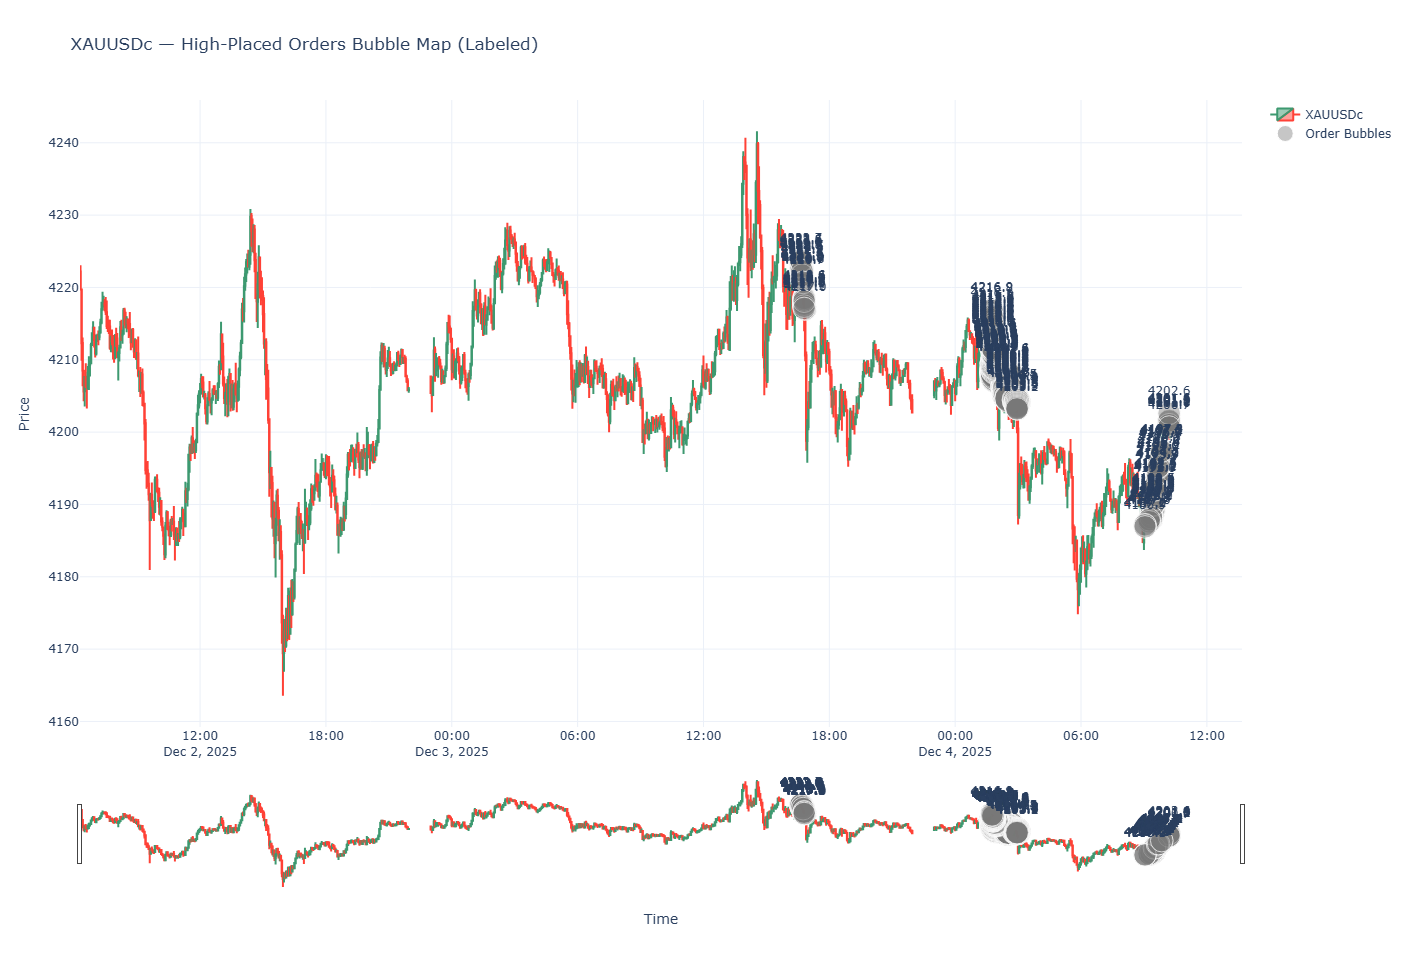

In [14]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import datetime as dt
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# -----------------------
# CONFIG
# -----------------------
SYMBOL = "XAUUSDc"
TIMEFRAME = mt5.TIMEFRAME_M3
LOOKBACK_BARS = 1000

USE_TICKS_FOR_DELTA = True
TICK_AGGREGATION_LIMIT = 100_000

VOLUME_QUANTILE = 0.68
MIN_BUBBLE_RADIUS = 14          # Bigger bubbles
BUBBLE_SCALE_FACTOR = 0.08      # Bigger scaling
MIN_TOUCHES = 2
PRICE_LEVEL_STEP = 0.10

OUTPUT_CSV = "xau_bubbles_zones.csv"
PLOTLY_OPEN_IN_BROWSER = True

# CHART SIZE (BIG)
CHART_WIDTH = 1800
CHART_HEIGHT = 950

# -----------------------
# MT5 INIT
# -----------------------
def mt5_init_or_exit():
    if not mt5.initialize():
        raise RuntimeError(f"MT5 init failed: {mt5.last_error()}")
    if not mt5.symbol_select(SYMBOL, True):
        raise RuntimeError(f"Symbol select failed: {SYMBOL}")

# -----------------------
# FETCH DATA
# -----------------------
def fetch_bars(symbol, timeframe, count):
    bars = mt5.copy_rates_from_pos(symbol, timeframe, 0, int(count))
    if bars is None or len(bars) == 0:
        raise RuntimeError("No bar data returned.")
    df = pd.DataFrame(bars)
    df["time"] = pd.to_datetime(df["time"], unit="s")
    df = df.set_index("time")
    return df

def price_bin(price, step):
    return round(round(price / step) * step, 2)

# -----------------------
# NODE DETECTION
# -----------------------
def detect_nodes_from_bars(df, price_step, min_touches, quantile):
    nodes = {}

    for ts, row in df.iterrows():
        low, high = row["low"], row["high"]
        vol = float(row["tick_volume"])
        price_points = np.arange(low, high + price_step, price_step)

        for p in price_points:
            pbin = price_bin(p, price_step)
            if pbin not in nodes:
                nodes[pbin] = {"touches": 0, "volume": 0.0, "bars": []}
            nodes[pbin]["touches"] += 1
            nodes[pbin]["volume"] += vol / max(1, len(price_points))
            nodes[pbin]["bars"].append(ts)

    nodes_df = pd.DataFrame([
        {
            "price": p,
            "touches": v["touches"],
            "volume": v["volume"],
            "last_touched": max(v["bars"])
        }
        for p, v in nodes.items()
    ])

    if nodes_df.empty:
        return nodes_df

    nodes_df = nodes_df[nodes_df["touches"] >= min_touches]
    vol_thresh = nodes_df["volume"].quantile(quantile)
    nodes_df["is_top"] = nodes_df["volume"] >= vol_thresh
    return nodes_df.sort_values("volume", ascending=False)

# -----------------------
# DELTA FROM TICKS
# -----------------------
def compute_delta(symbol, df_nodes):
    ticks = mt5.copy_ticks_from(symbol, dt.datetime.now() - dt.timedelta(days=2), 0, mt5.COPY_TICKS_ALL)
    if ticks is None or len(ticks) == 0:
        df_nodes["delta"] = np.nan
        return df_nodes

    tdf = pd.DataFrame(ticks)
    tdf["price"] = (tdf["bid"] + tdf["ask"]) / 2
    tdf["prev_price"] = tdf["price"].shift(1)
    tdf = tdf.dropna()
    tdf["dir"] = np.sign(tdf["price"] - tdf["prev_price"])
    tdf["price_bin"] = tdf["price"].apply(lambda x: price_bin(x, PRICE_LEVEL_STEP))

    deltas = []
    for _, node in df_nodes.iterrows():
        tsub = tdf[tdf["price_bin"] == node["price"]]
        up = (tsub["dir"] == 1).sum()
        down = (tsub["dir"] == -1).sum()
        total = up + down
        delta = (up - down) / total if total != 0 else 0
        deltas.append(delta)

    df_nodes["delta"] = deltas
    return df_nodes

# -----------------------
# PLOT WITH LABELS
# -----------------------
def plot_bubbles(df, nodes):
    fig = make_subplots(rows=1, cols=1)

    # Candlesticks
    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df["open"], high=df["high"],
        low=df["low"], close=df["close"],
        name="XAUUSDc"
    ))

    # Bubble visuals
    nodes = nodes.copy()
    sizes = np.sqrt(nodes["volume"] * BUBBLE_SCALE_FACTOR) * 2
    sizes = np.maximum(sizes, MIN_BUBBLE_RADIUS)

    colors = []
    delta_labels = []

    for d in nodes["delta"]:
        if d > 0.15:
            colors.append("rgba(0,200,0,0.65)")
            delta_labels.append("BUY")
        elif d < -0.15:
            colors.append("rgba(200,0,0,0.65)")
            delta_labels.append("SELL")
        else:
            colors.append("rgba(120,120,120,0.6)")
            delta_labels.append("NEUTRAL")

    labels = [
        f"{delta_labels[i]}<br>Price: {nodes.iloc[i]['price']}<br>Vol: {int(nodes.iloc[i]['volume'])}"
        for i in range(len(nodes))
    ]

    fig.add_trace(go.Scatter(
        x=nodes["last_touched"],
        y=nodes["price"],
        mode="markers+text",
        marker=dict(size=sizes, color=colors, line=dict(width=1)),
        text=[f"{nodes.iloc[i]['price']}" for i in range(len(nodes))],
        textposition="top center",
        hovertext=labels,
        name="Order Bubbles"
    ))

    fig.update_layout(
        title="XAUUSDc — High-Placed Orders Bubble Map (Labeled)",
        width=CHART_WIDTH,
        height=CHART_HEIGHT,
        template="plotly_white",
        xaxis_title="Time",
        yaxis_title="Price"
    )

    fig.show()

# -----------------------
# MAIN
# -----------------------
def main():
    mt5_init_or_exit()
    df = fetch_bars(SYMBOL, TIMEFRAME, LOOKBACK_BARS)
    nodes = detect_nodes_from_bars(df, PRICE_LEVEL_STEP, MIN_TOUCHES, VOLUME_QUANTILE)

    nodes = nodes[nodes["is_top"]]

    if USE_TICKS_FOR_DELTA:
        nodes = compute_delta(SYMBOL, nodes)
    else:
        nodes["delta"] = 0

    nodes.to_csv(OUTPUT_CSV, index=False)
    plot_bubbles(df, nodes)

    mt5.shutdown()

if __name__ == "__main__":
    main()


## Quick usage notes & tips

Install required packages:

pip install MetaTrader5 pandas numpy plotly

PRICE_LEVEL_STEP controls granularity. For XAUUSDc a step of 0.10 or 0.25 is common; smaller steps produce more nodes and slower computation.

USE_TICKS_FOR_DELTA = True gives you a directional estimate but can be slow for long ranges. Set TICK_AGGREGATION_LIMIT to constrain tick count.

Bubble size is influenced by BUBBLE_SCALE_FACTOR and MIN_BUBBLE_RADIUS.

If no nodes appear, try lowering MIN_TOUCHES or VOLUME_QUANTILE (e.g., 0.90).

The script distributes bar tick_volume across all price points touched in that bar. That’s a simple and robust approach but you can change the distribution logic (e.g., weight edges more).

The delta here is an estimate computed from tick upticks/downticks for ticks that fall exactly in the same price bin. Tick data availability/quality varies by broker — you may see many NaNs if ticks are sparse or MT5 doesn't supply last prices.

## Performance / production considerations

Fetching ticks across long ranges can be slow; for live dashboards use incremental tick fetching (only new ticks) and maintain an in-memory aggregation.

For high-throughput you should pre-aggregate on the MT5 side in smaller batches, or compute nodes offline periodically.

Consider storing computed nodes in a local DB (SQLite) keyed by date range so you don't recompute everything each run.

If you want near-live overlays in MT5 charts, consider converting the detection logic into a PineScript / MQL5 indicator — but MQL5 lacks easy tick-to-bar aggregation libraries; Python is usually more flexible.

##  Bubble Labels

Each bubble now shows:

Price level on the chart

Hover text with:

BUY / SELL / NEUTRAL

Exact price

Volume weight

## What This Is Now Perfect For

Liquidity zone mapping

Stop-hunt visualization

Smart-money entry tracking

Strategy filtering & confluence

Research paper figures

Institutional-style gold analysis